In [227]:
from pytrends.request import TrendReq
import pandas as pd
import re
import matplotlib.pyplot as plt
import scipy.stats as sci
import scipy.signal as signal
import numpy as np
import time
df = pd.read_csv('symptoms.csv', sep=',',encoding='latin-1')


In [128]:
#Test call to see whether I am still blocked by Google,lol
pytrend = TrendReq()

test = 'Anämie'
pytrend.build_payload(kw_list=['{}'.format(test)],geo="DE",timeframe='today 5-y',cat=0)
google_trend_per_syndrom = pytrend.interest_over_time()
google_values_unnormlised = google_trend_per_syndrom['{}'.format(test)].values
google_values= google_values_unnormlised/max(google_values_unnormlised)+0.0000001
print(google_trend_per_syndrom)
test_values = np.zeros((len(dict_symptomps_shortened),261))


            Anämie, isPartial
date                         
2013-02-17        0     False
2013-02-24        0     False
2013-03-03       36     False
2013-03-10        0     False
2013-03-17        0     False
2013-03-24        0     False
2013-03-31        0     False
2013-04-07        0     False
2013-04-14        0     False
2013-04-21        0     False
2013-04-28       37     False
2013-05-05        0     False
2013-05-12        0     False
2013-05-19       36     False
2013-05-26       35     False
2013-06-02        0     False
2013-06-09        0     False
2013-06-16        0     False
2013-06-23        0     False
2013-06-30        0     False
2013-07-07       38     False
2013-07-14        0     False
2013-07-21        0     False
2013-07-28       37     False
2013-08-04       37     False
2013-08-11        0     False
2013-08-18        0     False
2013-08-25        0     False
2013-09-01        0     False
2013-09-08        0     False
...             ...       ...
2017-07-23

# Data Cleaning

In [4]:
#If there are words in brackets and they start with a capital letter, keep and discard the rest
def word_in_bracket(x):
    match = re.search(r'.+?\(([A-Z].+)\)',x)
    if match is not None:
        return match.group(1)
    else:
        return x
    

In [5]:
#Cleaning of the data, as in the preprocessings scripts
df = pd.read_csv('symptoms.csv', sep=',',encoding='latin-1')
df.reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0','[PathogenMitKrankheit].[Meldeweg Web71].[Meldeweg ID Web71].[MEMBER_CAPTION]'])
df = df.rename(columns={'[PathogenMitKrankheit].[Meldeweg Web71].[Krankheit ID Web71].[MEMBER_CAPTION]': 'Krankheit', '[Symptome].[ID].[ID].[MEMBER_CAPTION]': 'Symptom', '[ReportingDate].[YearWeek].[YearWeek].[MEMBER_CAPTION]': 'Kalenderwoche', '[Measures].[FallCount]': 'Anzahl'}) 


df_selection = df.drop(columns='Krankheit')
df_selection['Symptom'] = df_selection['Symptom'].apply(lambda x: 'Durchfall' if x =="Durchfall und/oder Erbrechen" else x)
df_selection['Symptom'] = df_selection['Symptom'].apply(lambda x: 'Durchfall' if x =="Durchfall, nicht näher bezeichnet" else x)
df_selection['Symptom'] = df_selection['Symptom'].apply(lambda x: 'Muskel-, Glieder-, Rücken- oder Kopfschmerzen' if x =="Gliederschmerzen" else x)
df_selection['Symptom'] = df_selection['Symptom'].apply(lambda x: 'Hirnhautentzündung' if x.startswith("Meningitis") else x)
df_selection['Symptom'] = df_selection['Symptom'].apply(word_in_bracket)


df_selection_pivot = df_selection.groupby(['Symptom','Kalenderwoche'])['Anzahl'].sum().reset_index()
df_selection_pivot.sort_values('Kalenderwoche')
df_selection_all_symptoms = df_selection.groupby(['Symptom'])['Anzahl'].sum().reset_index()['Symptom'].tolist()



new_rows = []
for week in df['Kalenderwoche'].drop_duplicates().sort_values():
    for symptom in df_selection_all_symptoms:
        sample_week = df_selection_pivot[df_selection_pivot['Kalenderwoche'] == week]
        if not sample_week.isin({'Symptom': [symptom]})['Symptom'].any():
            new_row = [symptom, week, 0]
            new_rows.append(new_row)
            
            
new_values = pd.DataFrame(new_rows, columns=['Symptom','Kalenderwoche','Anzahl'])

#append these illnesses with 0 'Anzahl'
df_selection_pivot= df_selection_pivot.append(new_values)
df_weekly_symptoms = df_selection_pivot.sort_values('Kalenderwoche').reset_index(drop=True)
df_weekly_symptoms = df_weekly_symptoms.sort_values(['Kalenderwoche','Symptom'],ascending=[True,True])





In [6]:
#df_weekly_symptoms.to_pickle('df_weekly_symptoms.pkl')

In [6]:
#Create a dictonary of dataframes per symptom
dict_symptomps = {}
symptoms = set(df_weekly_symptoms["Symptom"])
symptoms = list(symptoms)
symptoms.sort()
dataframes = [df_weekly_symptoms[df_weekly_symptoms["Symptom"]=='{}'.format(symptom)] for symptom in symptoms]
dict_symptomps = dict(zip(symptoms,dataframes))

In [175]:
#To filter symptoms. Copy symptoms contains the original name and short symp the shortend version
#OLD VERSION
'''
def filter_symptoms(x):
    match = re.search(r'([A-Z]+[^\s,]*)[\s,]',x)
    if match:
        return match.group(1)
    
to_be_changed_symptoms = []
for i, symp in enumerate(dict_symptomps):
    to_be_changed_symptoms.append(symp)


filtered_symp = map(filter_symptoms, to_be_changed_symptoms)
filtered_symp = list(filtered_symp)

copy_symptoms = symptoms.copy()

#Save the index where None
index =[]
for i in range(len(filtered_symp)):
    if filtered_symp[i] == None:
        index.append(i)
#Delete where entry is None
for i in range(len(index)):
    del filtered_symp[index[i]]
    del copy_symptoms[index[i]]
    index[:] = [x - 1 for x in index]
    
               

print((filtered_symp))
'''

"\ndef filter_symptoms(x):\n    match = re.search(r'([A-Z]+[^\\s,]*)[\\s,]',x)\n    if match:\n        return match.group(1)\n    \nto_be_changed_symptoms = []\nfor i, symp in enumerate(dict_symptomps):\n    to_be_changed_symptoms.append(symp)\n\n\nfiltered_symp = map(filter_symptoms, to_be_changed_symptoms)\nfiltered_symp = list(filtered_symp)\n\ncopy_symptoms = symptoms.copy()\n\n#Save the index where None\nindex =[]\nfor i in range(len(filtered_symp)):\n    if filtered_symp[i] == None:\n        index.append(i)\n#Delete where entry is None\nfor i in range(len(index)):\n    del filtered_symp[index[i]]\n    del copy_symptoms[index[i]]\n    index[:] = [x - 1 for x in index]\n    \n               \n\nprint((filtered_symp))\n"

In [176]:
#To filter symptoms. Copy symptoms contains the original name and short symp the shortend version
#IMPROVES,CURRENT VERSION
def filter_symptoms(x):
    match = re.search(r'([A-Z]+[^\s]*)[\s]',x)
    if match:
        match = match.group(1)
        if re.search(r'([A-Z]+[^\s,-]*)[\s,-]',match):
            match = re.search(r'([A-Z]+[^\s,-]*)[\s,-]',match)
            return match.group(1)
        else:
            return match
    
to_be_changed_symptoms = []
for i, symp in enumerate(dict_symptomps):
    to_be_changed_symptoms.append(symp)


filtered_symp = map(filter_symptoms, to_be_changed_symptoms)
filtered_symp = list(filtered_symp)

copy_symptoms = symptoms.copy()

#Save the index where None
index =[]
for i in range(len(filtered_symp)):
    if filtered_symp[i] == None:
        index.append(i)
#Delete where entry is None
for i in range(len(index)):
    del filtered_symp[index[i]]
    del copy_symptoms[index[i]]
    index[:] = [x - 1 for x in index]
    
               



['Protein', 'Abschuppen', 'Absinken', 'Anzeichen', 'Anämie', 'Appetit', 'Atemstillstand', 'Atrophie', 'Atypische', 'Aufnahme', 'Aufnahme', 'Ausschlag', 'Ausschlag', 'Ausschlag', 'Ausschluss', 'Beläge', 'Blutstuhl', 'Blutung', 'Brennen', 'Demenz', 'Durchfall', 'Durchfall', 'EEG', 'EEG', 'Eiteransammlung', 'Entzündung', 'Entzündung', 'Entzündung', 'Erbrechen', 'Erregtheit', 'Erschöpfung', 'Erythema', 'Fetales', 'Flächige', 'Fokus', 'Granulomatosis', 'Haut', 'Haut', 'Hautausschlag', 'Hauteinblutungen', 'Hautinfiltrationen', 'Hautläsion', 'Hautläsion', 'Herabhängen', 'Herzfehler', 'Herzrhythmusstörung', 'Himbeer', 'Hirndruckzeichen', 'Hirnnervenstörung', 'Husten', 'Hämatokrit', 'Impetigo/Pyodermie', 'Infektion', 'Infektion', 'Katarrh', 'Klinische', 'Klinisches', 'Klinisches', 'Klinisches', 'Klinisches', 'Klinisches', 'Klinisches', 'Klinisches', 'Klinisches', 'Klinisches', 'Klinisches', 'Kopliksche', 'Lymphknotenschwellung', 'Lähmung', 'Lähmung', 'Muskel', 'Muskel', 'Nachweis', 'Phlegmone',

In [177]:
#The indices of the symptoms which can be known to normal people, merged to a dict

indices = [4,11,12,13,14,16,18,20,21,24,25,26,27,28,36,37,38,39,41,42,46,47,48,49,52,53,67,70,71,76,77,111]
reduced_keys = [copy_symptoms[indices[i]] for i in range(len(indices))]
reduced_short_keys = [filtered_symp[indices[i]] for i in range(len(indices))]

dataframes_for_short = [df_weekly_symptoms[df_weekly_symptoms["Symptom"]=='{}'.format(key)] for key in reduced_keys]
dict_symptomps_shortened = dict(zip(reduced_keys,dataframes_for_short))


In [185]:
#Extract the rki data for the last 261 weeks for the selected symptomps

rki_values = np.zeros((len(dict_symptomps_shortened),261))

for i, symptom in enumerate(reduced_keys):
    rki_timeseries = dict_symptomps['{}'.format(symptom)]
    rki_timeseries = rki_timeseries[-261:]
    rki_values_unnormlised = rki_timeseries['Anzahl'].values
    if max(rki_values_unnormlised) !=0:
        rki_values[i,:] = rki_values_unnormlised/max(rki_values_unnormlised)
    else:
        rki_values[i,:] = 0

In [188]:
#Extracts the google trend data for the last 261 weeks for the selected symptomps

google_values = np.zeros((len(dict_symptomps_shortened),261))
pytrend = TrendReq()

for i, symptom in enumerate(reduced_short_keys):
    try:
        pytrend.build_payload(kw_list=['{}'.format(symptom)],geo="DE",timeframe='today 5-y',cat=0)
        google_trend_per_syndrom = pytrend.interest_over_time()
        google_values_unnormlised = google_trend_per_syndrom['{}'.format(symptom)].values
        if max(rki_values_unnormlised) !=0:
            google_values[i,:] = google_values_unnormlised/max(google_values_unnormlised)
        else:
            google_values[i,:] = 0        
        time.sleep(10)
    except:
        print('exception for',symptom)


exception for Hirnnervenstörung


In [189]:
HARDCORE_COPY = google_values.copy()

In [194]:
#google_values.dump('google_values.pkl')
#rki_values.dump('rki_values.pkl')

# Correlation and Plotting of Data

In [223]:
#Zero centering, decorrelation, and correlation of rki and google data per symptom
correlation_values = np.zeros((len(rki_values)))
p_values = np.zeros((len(rki_values)))
for i in range(len(rki_values)):
    try:
        output_tuple = sci.pearsonr(google_values[i],rki_values[i])
        correlation_values[i] = output_tuple[0] 
        p_values[i] = output_tuple[1]
    except RuntimeWarning:
        print('shits on fire')


/home/student/a/aabbood/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


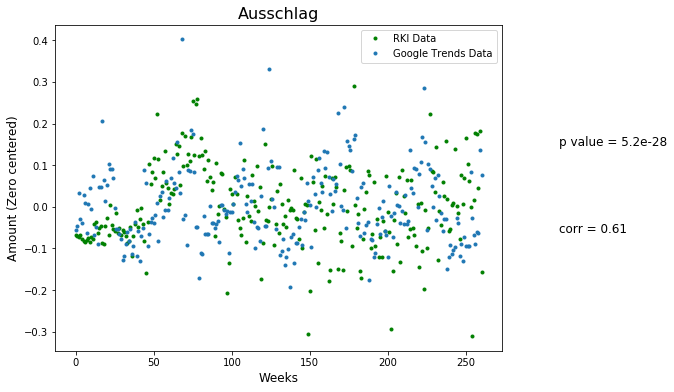

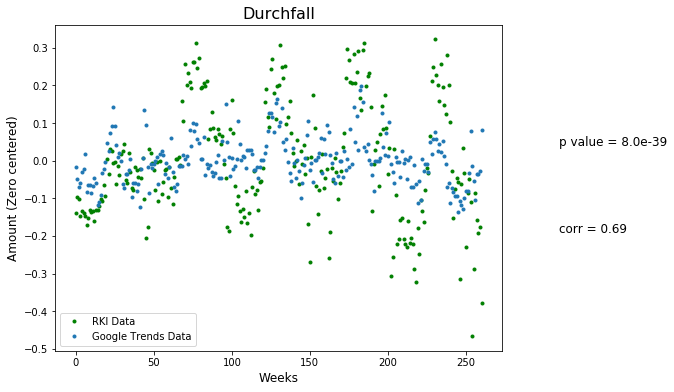

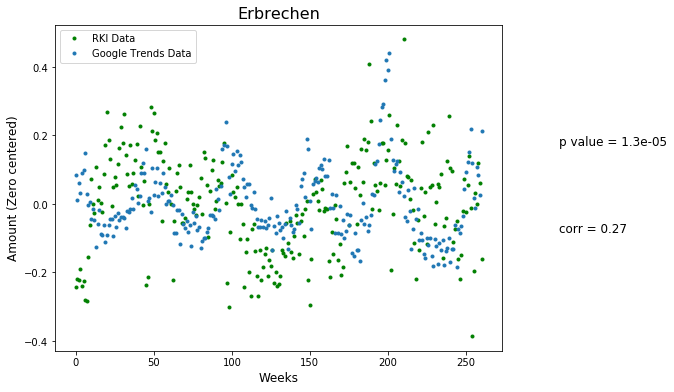

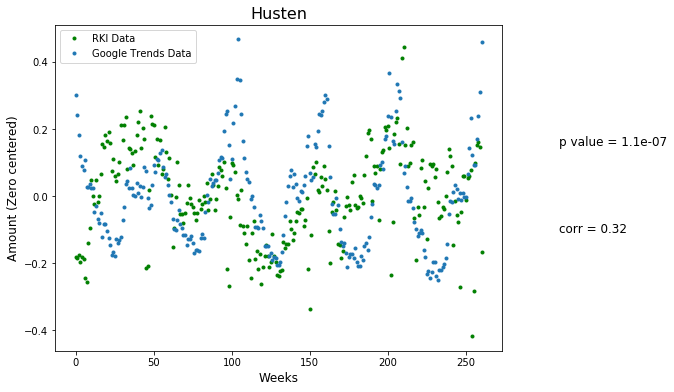

In [285]:
#Plotting
y = range(261)
interesting_plots = [3,8,13,23]
#subplots = [(0,0),(0,1),(1,0),(1,1)]
#fig, axes = plt.subplots(2, 2)

for i in range(len(reduced_keys)):
    if i in interesting_plots:
        rki_norm = rki_values[i] - np.mean(rki_values[i]) / np.std(rki_values[i])
        google_norm = HARDCORE_COPY[i] - np.mean(HARDCORE_COPY[i]) / np.std(HARDCORE_COPY[i])

        rki_norm = np.nan_to_num(rki_norm)
        google_norm = np.nan_to_num(google_norm)

        plt.figure(figsize=(8,6))
        plt.plot(y,signal.detrend(rki_norm,type='linear'),'g.')
        plt.plot(y,signal.detrend(google_norm,type='linear'),'.')
        plt.xlabel('Weeks',fontsize=12)
        plt.ylabel('Amount (Zero centered)',fontsize=12)
        plt.title('{}'.format(reduced_short_keys[i]),fontsize=16)
        plt.legend(['RKI Data','Google Trends Data'], fontsize=10)
        plt.gcf().text(1, 0.4, 'corr = {}'.format(round(correlation_values[i],2)), fontsize=12)
        plt.gcf().text(1, 0.6, 'p value = {:.1e}'.format(p_values[i]), fontsize=12)

        plt.show()
        #time.sleep(3)